# Practical Statistic workshop
#### one of the overarching questions in this workshop:
## What does "statistically significant" actually mean?

In [1]:
%config IPCompleter.greedy=True
import seaborn as sns
import numpy as np
from scipy import stats
from pylab import plt
import pandas as pd
sns.set_style("ticks")

background mean:0
background std:1
empirical mean:0.01493204823353797
empirical std:0.6222104778000812


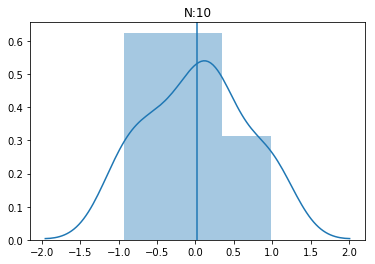

In [12]:
# create a sample from a normal distribution
N = 10
scale=1
loc=0  # mean of the underlying distribution
mysample = stats.norm.rvs(loc=loc,scale=scale,size=N)
# now we compute the empirical mean of the distribution, thus the 
# mean computed from the sampel
empirical_mean = np.mean(mysample)
empirical_std = np.std(mysample)
print(f'background mean:{loc}')
print(f'background std:{scale}')
print(f'empirical mean:{empirical_mean}')
print(f'empirical std:{empirical_std}')

plt.figure()
sns.distplot(mysample)
plt.axvline(empirical_mean)
plt.title('N:'+str(N))
plt.show()
# rerun this cell (press ctrl-enter) a couple of times and see how the empirical mean changes.
# note that we KNOW that the mean of the real distribution is 0!
# try out also other values for N

Here we establish a concept that will be very important : the difference between the
### Background Distribution
and the 
### Empirical Distribution
The empirical distribution is what we actually get from observations (observations are meant here in a broad sense, so the output of numerical models for example would also count as observataions). The background distribution is usually not known, but is what we want to estimate. In this workshop we use random number generators to generate empirical distributions, and we actually know the background distributions of these random number generators.

# comparing the mean of 2 distributions
Do two distributions have a different mean?
Let's say we have 2 series of measurements from 2 different groups.
Now what does it actually mean the the difference in the mean of the groups is "statistically significant"?
We can explore this by again drawing smaples fro known distributions

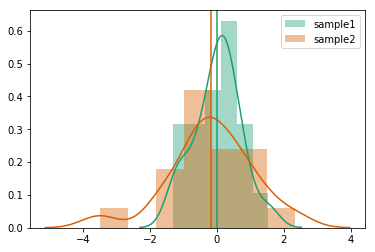

In [16]:
N1=20
N2=N1
# let's start with a case where the 2 distributions do actually have different means (defined via the loc parameter)
# our null-hypothesis: mean1 > mean2
loc1=0
loc2=0.2
scale1=1
scale2=1
# draw one samle of size N1 from each background distribution
sample1=stats.norm.rvs(loc=loc1,scale=scale1,size=N1)
sample2=stats.norm.rvs(loc=loc2,scale=scale2,size=N2)

# compute the mean of each sample
emp_mean1=np.mean(sample1)
emp_mean2=np.mean(sample2)

# plot both distributions and their means
colors=['#1b9e77', '#d95f02', '#7570b3']
plt.figure()
sns.distplot(sample1, label='sample1', color=colors[0])
sns.distplot(sample2, label='sample2', color=colors[1])
plt.axvline(emp_mean1, color=colors[0])
plt.axvline(emp_mean2, color=colors[1])
plt.legend()
plt.show()

## again, rerun this a couple of times
## also try out other values of N. You will find that sometimes the epmirical mean of the distribution
## with greater mean will be smaller than the empirical mean of the distribution with the smaller mean


In [19]:
# now we do the same thing, but a lot of times (1000) times:
# each time, we draw a sample of N from the 2 background-distributions, and compute
# the empirical mean of the samples

N_iter=1000
N=100
means1=[]
means2=[]
for i in range(N_iter):
    sample1=stats.norm.rvs(loc=loc1,scale=scale1,size=N1)
    sample2=stats.norm.rvs(loc=loc2,scale=scale2,size=N2)
    means1.append(np.mean(sample1))
    means2.append(np.mean(sample2))
    
means1=np.array(means1)    
means2=np.array(means2)
diff = means1-means2

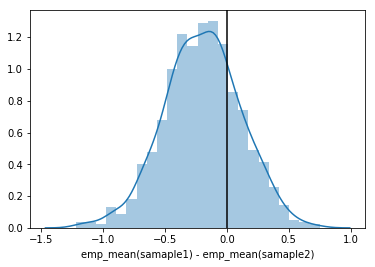

In [20]:
# now we plot a histogram of the differenc of the means (so for every iteration N_iter, we compute the difference
# between the empirical mean of sample1 and sample 2)
plt.figure()
sns.distplot(diff)
plt.axvline(0, color='black')
plt.xlabel('emp_mean(samaple1) - emp_mean(samaple2)')
plt.show()

In [21]:
# we knoww that the underlying distributions of our 2 groups have different mean, and that mean2 > mean1 (we specified this!), but still we now see
# that in some cases, when drawing two samples of size N from the underlying the distributions, it appreas to be different:
# for the empirical means, sometimes mean2<mean1 ! This is the problem of empirical means: they are uncertain!
# now a statement "mean2>mean1 with a significance of 0.95" actually means: if in reality mean2<mean1, then only 5 % of realisations
# would show mean2>mean1
# here, we can approach this "from the other side", since we can generate random realisations at our will,
# and we can count how the percentage of "wrong" outcomes is

In [22]:
perc_mean1_st_mean2 = len(diff[diff>0])/len(diff)
print(perc_mean1_st_mean2)

0.255


In [23]:
# this is now the fraction of cases where - given the background-distributions that we specified- by chance you would 
# get a false result
# if you increase N1 and N2, this number will decrease (try it out!). Sideremark: this fraction will change 
# slightly if you run the script again - this the uncertainty by the finit sampling of realistations (N_iter). The 
# bigger N_iter, the less perc_mean1_st_mean2 will change

# Correlations

<Figure size 432x288 with 0 Axes>

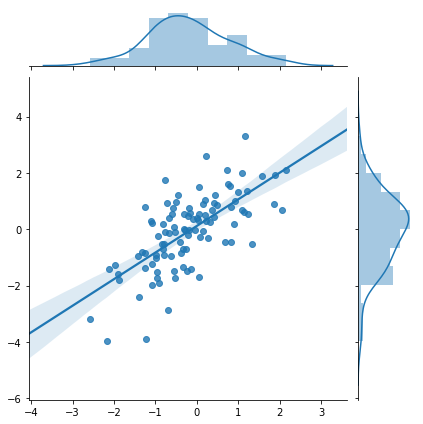

In [24]:
# create a 2-variable dataset that has correlation "build-in"
x = stats.norm.rvs(size=100)
alpha=0.9
y = x + alpha*stats.norm.rvs(size=100)
plt.figure()
sns.jointplot(x,y, kind='reg')

<Figure size 432x288 with 0 Axes>

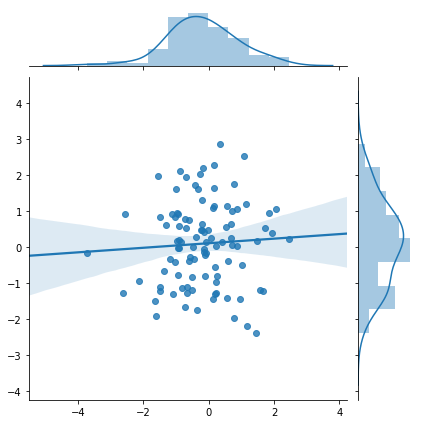

In [25]:
# create a 2-variable dataset that has no correlation (x and y are independent random variables)
N=100
x = stats.norm.rvs(size=N)
y = stats.norm.rvs(size=N)
plt.figure()
sns.jointplot(x,y, kind='reg')
# the blue shading shows the 5-95 confidence interval for the regression. If the shading does not cross the zero-line,
# then this means there is correlation with signifiance of 0.9
# if you run this cell often enough, you find something interesting: from time to time 
# (the smaller N, the more often this will happen), there will be significant
# correlation. Even though we know that the background-distributions are uncorrelated!

In [26]:
# let's automatize this. We draw random samples x and y, and compute the correlation
# for this we use a bootstrapping function. We will come back to bootstrapping later, for now just
# accept that the function below returns the confidence interval of the correlation of its inputs
# x and y.
def bootstrapped_correlation(x,y,perc=5,N=1000):
    assert(len(x)==len(y))
    corrs = []
    for i in range(N):
        indices = np.random.choice(len(x), replace=True, size=len(x))
        corr = np.corrcoef(x[indices], y[indices])[0,1]
        corrs.append(corr)
    corrs=np.array(corrs) 
    #corrs = sns.algorithms.bootstrap(x,y,func=lambda x,y:np.corrcoef(x,y)[0,1])
    meancorr = np.corrcoef(x,y)[0,1]
    upper = np.percentile(corrs,q=100-perc)
    lower = np.percentile(corrs,q=perc)
    
    return meancorr,lower,upper

N_iter = 100
res = []
for i in range(N_iter):
    x = stats.norm.rvs(size=N)
    y = stats.norm.rvs(size=N)
    meancorr,lower,upper = bootstrapped_correlation(x,y)
    # if both the upper and the lower are below zero, or both are above zero
    # then we have significant correlation
    is_significant = np.sign(upper) == np.sign(lower)
    res.append(is_significant)
res = np.array(res)

In [27]:
# compute the fraction of cases where we found spurious correlation
fraction_spurios_correlation = np.mean(res)
print(fraction_spurios_correlation)    

0.14


In [28]:
# this should be close to our conficende interval used in the bootstrapping (5-95, thus 0.10)
# but in fact it seems to be twice as high. Can you think of a reason? Did we formulate our Null-hypothesis
# correctly?

# Highly-dimensional datasets

The above mentioned issues (that a random process will yield significant correlation/difference/etc from time to time, has very important implications when analyzing high dimensional datasets.
Here, "dimensional" is very general, and does not only relate to space or time dimensions. It can also mean many different variables. For example, if you have spatial data at 10x10 gridpoints, you have 10x10=100 variables, and thus the dimensionality of the data is not 2 but 100. 

<Figure size 432x288 with 0 Axes>

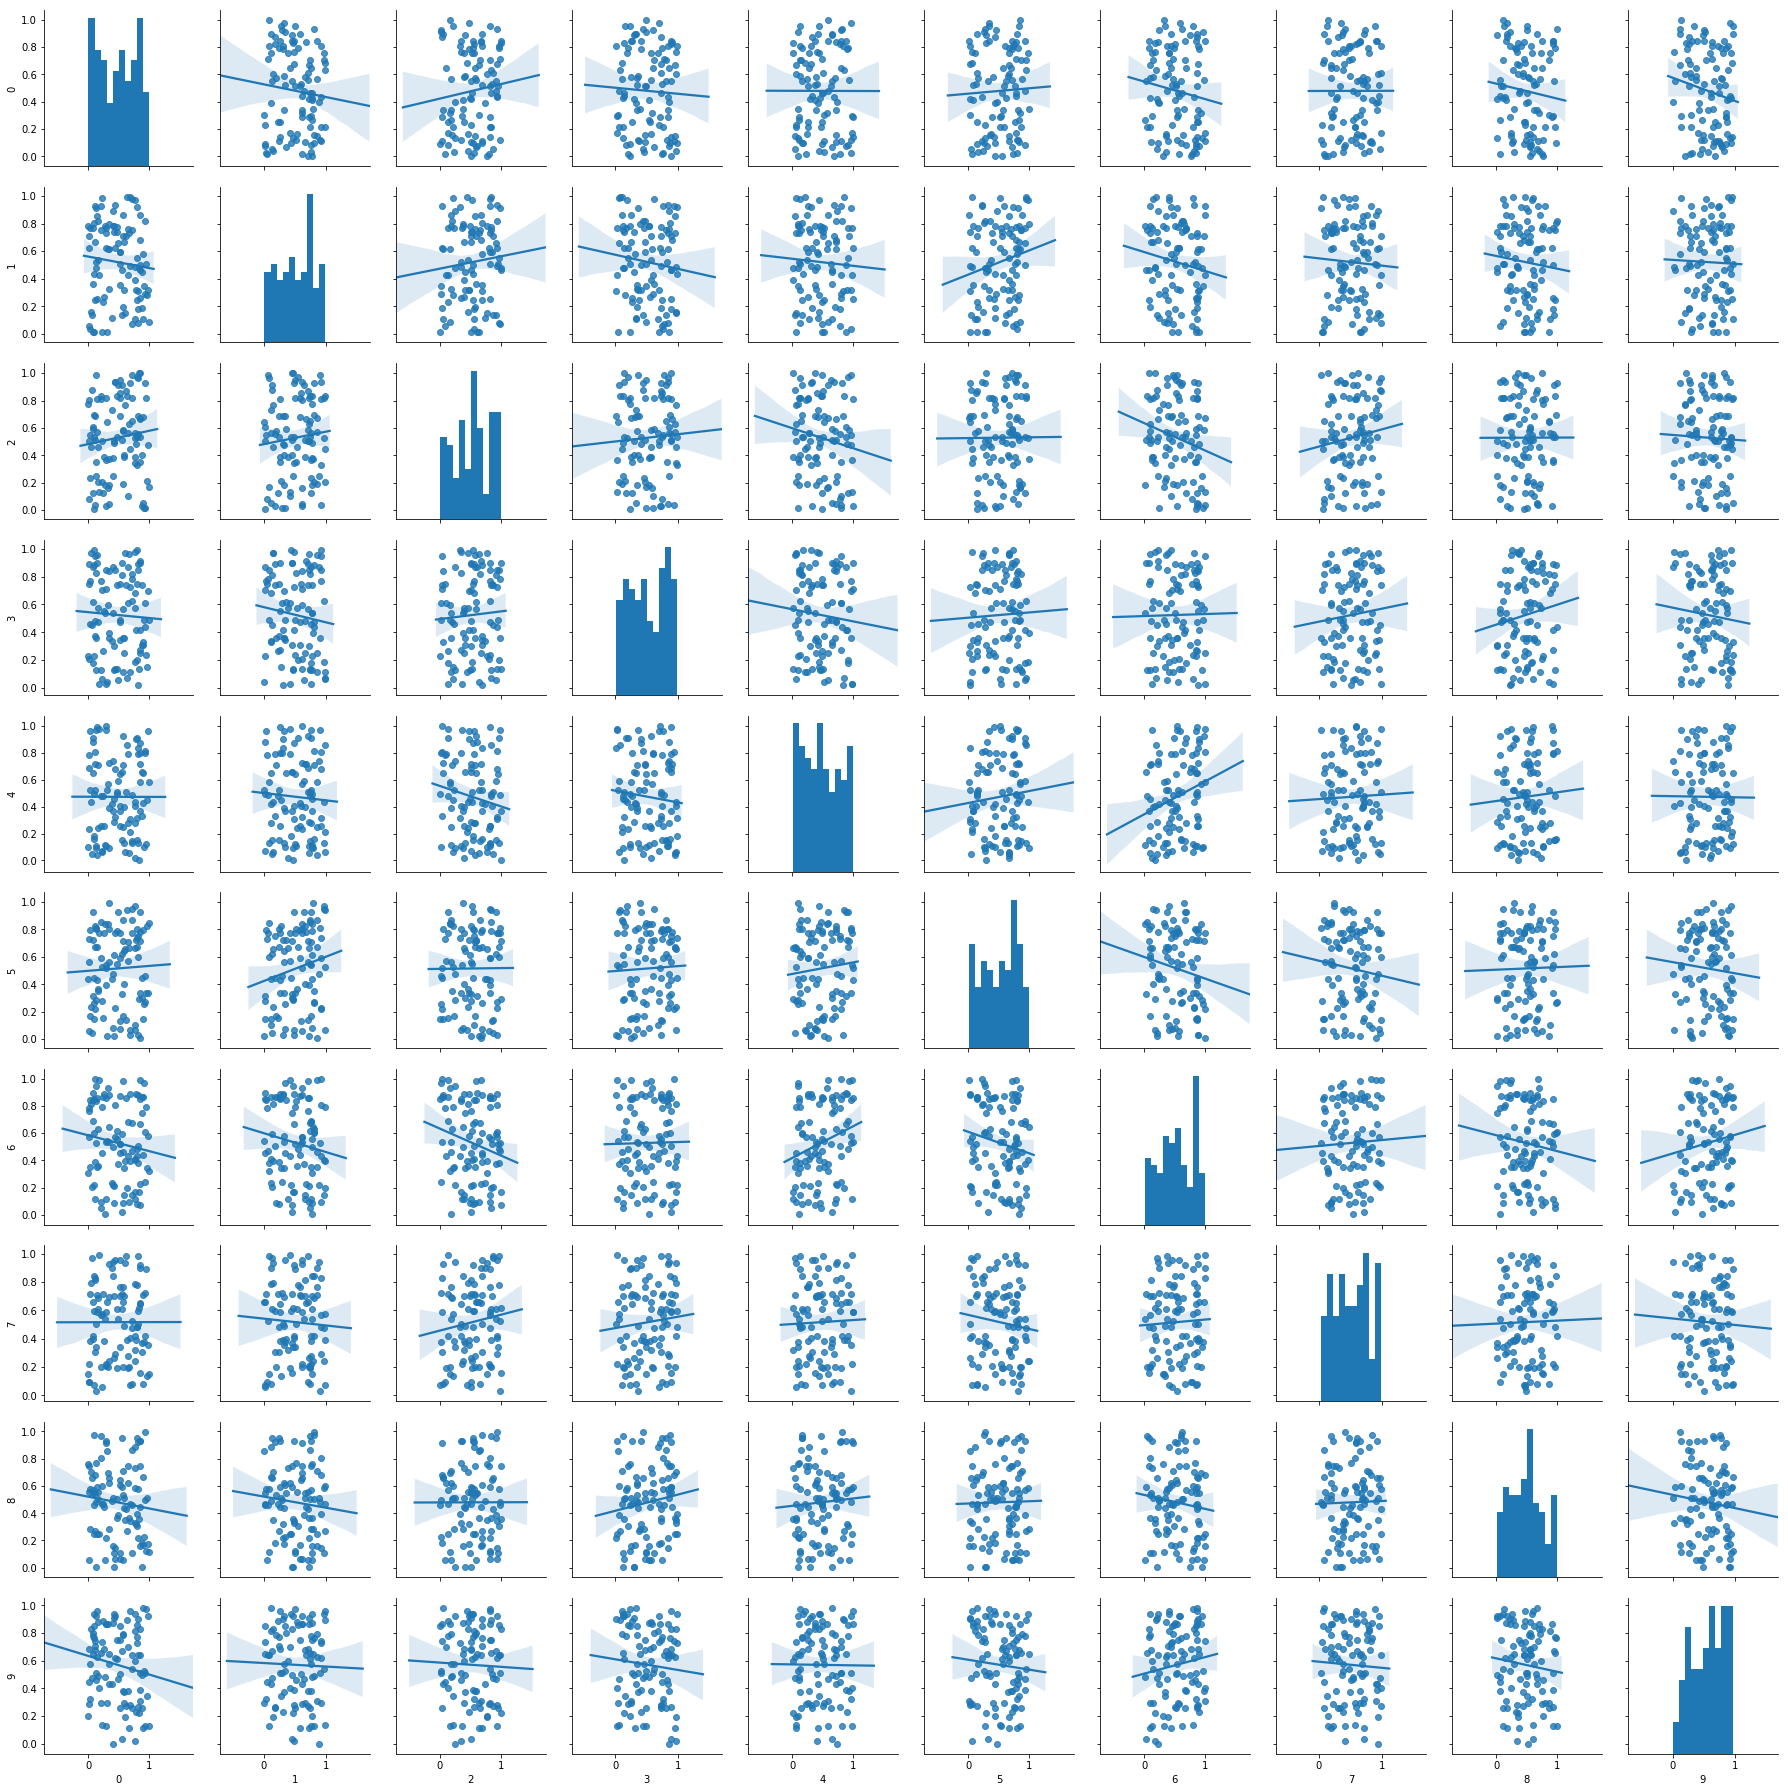

In [29]:
# let's create some random data
# assume that we have
Ndim = 10
# different variables, all random and uncorrelated, and for each variable we have
N= 100
# observations
df = pd.DataFrame(np.random.random((N,Ndim)))

# nowmake a matrix plot with bootstrapped correlation
plt.figure()
sns.pairplot(df, kind='reg')
#this command can take a while



## can you find pairs that have significant correltaion?
## what does that mean?



In [30]:
# now compute the signifianc for every pair
res_is_sig = []
for i in range(Ndim):
    print(i)
    for j in range(Ndim):
        if i != j:
            meancorr,lower,upper = bootstrapped_correlation(df[i], df[j], N=100) # we use only 100 bootstraps to speed things up
            is_significant = np.sign(upper) == np.sign(lower)
            res_is_sig.append(is_significant)
            

print('fraction of significant pairs:',np.mean(res_is_sig))

0
1
2
3
4
5
6
7
8
9
fraction of significant pairs: 0.12222222222222222


It is easy to automatize this process, and "mine" for correlations in the data. This is what we often do in 
exploratory data analysis. Hoever, this approach is potentially *fundamentally flawed*. The approach of using p-values for deciding on significance is only valid if you *first* set up a hypothesis - ideally based on prior knowledge, physical intuition etc, and afterwards* test in on data. The p-value is then the probability that a random process yields your result.
If you simply mine your data, you arbitrarily set up hypothesis and test them.
### Q: how do we approach this in our field of science?

### another example: difference between maps showing time-mean values

significant area fraction: 0.085 for p=0.95 (alpha=0.050000000000000044)


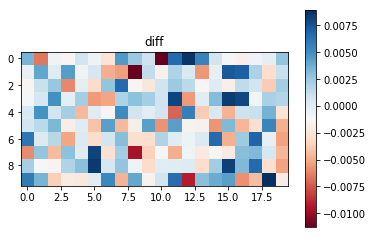

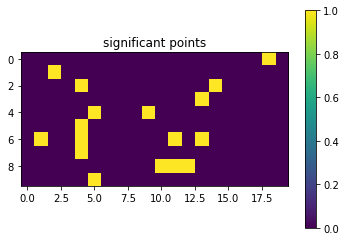

In [31]:
N = 10000
Nx = 10
Ny = 20
data3d1 = np.random.random((N,Nx,Ny))
data3d2 = np.random.random((N,Nx,Ny))
# compute time mean
mean1 = np.mean(data3d1, axis=0)
mean2 = np.mean(data3d2, axis=0)
plt.figure()
plt.imshow(mean1-mean2, cmap=plt.cm.RdBu); plt.colorbar()
plt.title('diff')


# is the difference in the mean significant?
# since we have normal data, we use a t-test here instead of bootstrapping (for speed)
p = 0.95
is_sig = np.zeros((Nx,Ny))
for i in range(Nx):
    for j in range(Ny):
        
        _, pfromtest = stats.ttest_ind(data3d1[:,i,j], data3d2[:,i,j])
        if pfromtest > p :
            is_sig[i,j] = 1
        else:
            is_sig[i,j] = 0

            
plt.figure()
plt.imshow(is_sig)
plt.title('significant points')
plt.colorbar()
# now compute the area that passed the test
sig_area_fraction = np.sum(is_sig) / (Nx*Ny)
print(f'significant area fraction: {sig_area_fraction} for p={p} (alpha={1-p})')

## rerun this a couple of times,(also try out different p-vals). What is the fraction is significant points
## you get on average?


### now we know how much "spurios" points we can expect. Now how to deal with this?
### any ideas?

# Computing confidence intervals for (nearly) whatever type of data/plot
# Bootstrapping
Up to now, we used the bootstrapping function (and the bootstrapping built into seaborn) as a black-box. you simply had to believe that it made sense.
Here we will discuss why this is actually the case

The principle goal behind bootstrapping is to get the *undertainty of an empirical distribution*, given the empirical distribution.

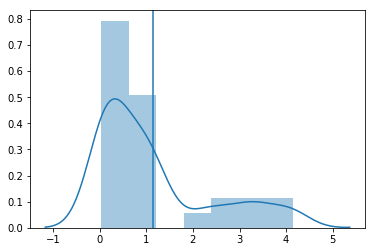

In [32]:
# lets say we have the following data (e.g. from an experiment)
expdata = np.array([0.07047472, 3.33453415, 0.05658453, 2.4356657 , 0.70741267,
       1.04390018, 1.1783881 , 0.18144047, 0.46671969, 0.07755574,
       0.21910896, 0.03822302, 0.16925173, 0.84388231, 1.18402365,
       4.15818062, 0.24154752, 2.16320588, 2.8907313 , 0.16688633,
       1.16460308, 1.17720384, 0.32996651, 0.16892912, 0.77367657,
       3.35677442, 0.14811093, 3.99420697, 0.62633901, 0.98861266])

N = len(expdata)
# we can plot the distribution of the empirical data
sns.distplot(expdata)
plt.axvline(np.mean(expdata))
# cleary, the data is not normally distributed, and we do not know how it is distributed for example, 
# rainfall data might look similar

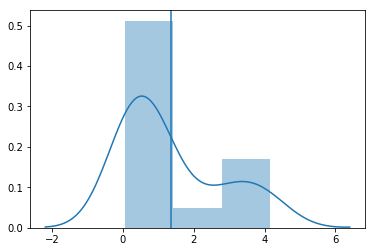

In [33]:
# however, how certain are we that this distribution really reflects the background distribution
# of the data?
# this is very similar to the very beginning of this workshop, were we created empirical distributions
#from a known distribution.
# to get a feeling about how uncertatin the empirical distribution, we simple reran the random generator a couple 
# of times.
# However, here we cannot do this - this would mean repeating the experiment. But is there a way to get an 
# idea of the uncertainty in the empirical distrubiton without running addidionatl experiments, thus only
# from the data?
# the solution is to run "fake"-experiments. Instead of generating real new distributions (what we would do
# in an experiment, we generate new distributions from the data we already have)
# this we do via randomly drawing with replacing.
# if we have N samples, we draw N individual samples, putting back the one we drew (so in the end
# we can draw a specific sample multiple times)
# this can be done with the random.choice function
newdata = np.random.choice(expdata, size=N, replace=True)
sns.distplot(newdata)
plt.axvline(np.mean(newdata))
# run this a couple of times, and compare it with the plot of the original expdata above

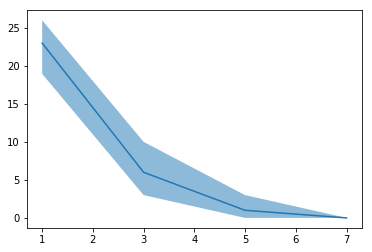

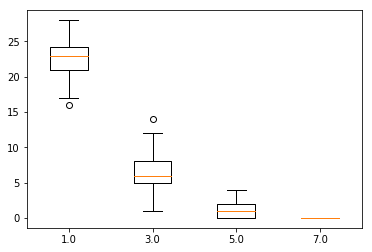

In [34]:
# The changes from repetition to repitition indicate the uncertaint, including the position of the mean (vertical
# line)
# now we will quantify this
N_boot = 100
res = []
for _ in range(N_boot):
    newdata = np.random.choice(expdata, size=N, replace=True)
    res.append(newdata)
    
# now we have a 2d array res (N_boot,N), and each row contains one realization of the random drawing
# from the expdata
# now we compute a histogram for every realization
bins = np.arange(0,10,2)
hists = np.array([np.histogram(row, bins=bins)[0] for row in res])
boot_median = np.median(hists,axis=0)
boot_upper = np.percentile(hists,q=95,axis=0)
boot_lower = np.percentile(hists,q=5,axis=0)
# note that here median is NOT the median of the empirical distribution, but it is the median
# over the bootstraps, computed individually for each histogram bin

bin_centers = (bins[1:] + bins[:-1])/2 # necessary for plotting



plt.figure()
plt.plot(bin_centers,boot_median, label='boot_median')
plt.fill_between(bin_centers,boot_lower,boot_upper, label='boot_median', alpha=0.5)

# we can also make a boxplot
plt.figure()
_ = plt.boxplot(hists,labels=bin_centers)  # the _= is necessary to suppress output in the notebook



## and voila: now we have an estimate of the uncertainty of our distribution!
now can take this one step further, and extend it to any measure of our distribution (e.g. mean, median, but also more complicated like the RMSE of data etc)


mean of mean:1.15, confidence interval: 0.74-1.50


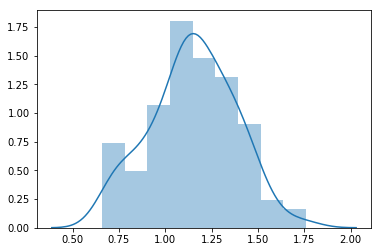

In [35]:
# compute uncertainty of the mean of the distribution
N_boot = 100
means = []
for _ in range(N_boot):
    newdata = np.random.choice(expdata, size=N, replace=True)
    mean_of_this_sample = np.mean(newdata)
    means.append(mean_of_this_sample)
    
sns.distplot(means)
mean_of_means = np.mean(means)
upper = np.percentile(means,q=95)
lower = np.percentile(means,q=5)
print(f'mean of mean:{mean_of_means:.2f}, confidence interval: {lower:.2f}-{upper:.2f}')


In [36]:
## PYTHON-SPECIFIC
## generalizing this to arbitary estimatros is easy in python:



def bootstrapped_ci(data, estimator, ci=95, N=1000):
    """
    compute a confidence interval over data using estimator with bootstrapping
    :param data: input data
    :param estimator: callable, function that returns a single scalar value (e.g. np.mean)
    :param ci: float, [0-100]
    :param N: number of bootstrapts
    :return: mean, lower, upper
    """

    res = []
    for i in range(N):
        newdata = np.random.choice(data, size=N, replace=True)
        # apply function
        estimated = estimator(newdata)
        res.append(estimated)
    res = np.array(res)
    mmean = np.mean(res)
    upper = np.percentile(res, q=100 - (100 - ci)/2)
    lower = np.percentile(res, q=(100-ci)/2)

    return mmean, lower, upper



# example: using np.mean
mmean, lower, upper = bootstrapped_ci(expdata, estimator=np.mean, ci=95)
print(f'mean of mean:{mmean:.2f}, confidence interval: {lower:.2f}-{upper:.2f}')

# example: using np.meadian
mmedian, lower, upper = bootstrapped_ci(expdata, estimator=np.median, ci=95)
print(f'mean of median:{mmedian:.2f}, confidence interval: {lower:.2f}-{upper:.2f}')

mean of mean:1.15, confidence interval: 1.07-1.22
mean of median:0.74, confidence interval: 0.71-0.77


In [37]:
# for correlation it is a bit more tricky, because correlation is a 2-variable estimator
# here, we cannot independently make new distributions from the dataset, but we always must choose pairs


# this is what the mysterious functio nwe used earlier does:
def bootstrapped_correlation(x,y,perc=5,N=1000):
    assert(len(x)==len(y))
    corrs = []
    for i in range(N):
        indices = np.random.choice(len(x), replace=True, size=len(x))
        corr = np.corrcoef(x[indices], y[indices])[0,1] # np.coorcoef returns a correlation matrix, extract [0,1]
        corrs.append(corr)
    corrs=np.array(corrs) 
    meancorr = np.corrcoef(x,y)[0,1]
    upper = np.percentile(corrs,q=100-perc)
    lower = np.percentile(corrs,q=perc)
    
    return meancorr,lower,upper




## bootstrapping built into seaborn

In [39]:
# load some example data
iris = sns.load_dataset('iris')


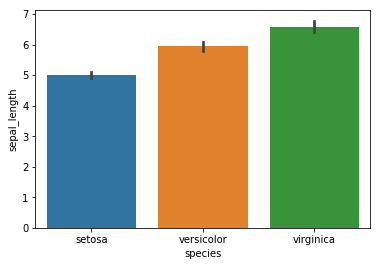

In [43]:
sns.barplot('species','sepal_length',  data=iris)
# if not specified otherwise, nearly all seaborn plots automatically include uncertainty estimates of the mean (ci=95)
# if we plot "species" vs "sepal_length", then for each species, the mean is computed over all samples, and
# plotted as a bar. additionally, the uncertainty in this mean is plotted as small bars



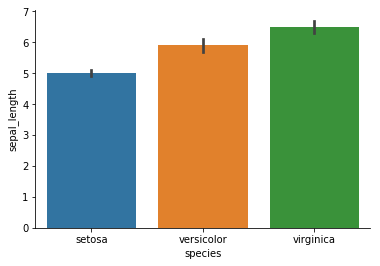

In [48]:
# if you do not want the mean, but another estimator, you can explicitely pass an estimarot
sns.barplot('species','sepal_length',  data=iris, estimator=np.median)

In [45]:
# timeseris
fmri = sns.load_dataset("fmri")

In [46]:
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
5,s9,18,stim,parietal,-0.103513
6,s8,18,stim,parietal,-0.064408
7,s7,18,stim,parietal,-0.060526
8,s6,18,stim,parietal,-0.007029
9,s5,18,stim,parietal,-0.040557


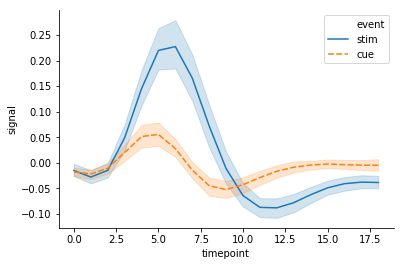

In [49]:
sns.lineplot(x="timepoint", y="signal",  hue="event", style="event", data=fmri)
sns.despine()
